# Historical Data Platform QA/QC Event Evaluation Procedure

| Event | Start Date | End Date | Location | Variables to Evaluate |
|-------|------------|----------|----------|-----------------------|
|Santa Ana Wind|2/16/1988|2/19/1988|Los Angeles, Orange Counties|wind speed, wind direction, air temperature, humidity|
|Winter Storm | 12/20/1990|12/24/1990| WECC, Sac Valley, Oakland|air temperature, pressure, precipitation|
|AR|1/16/2017|1/20/2017|CA, coastal WECC|precipitation, wind speed, wind direction|
|Mudslide|1/5/2018|1/9/2018|Santa Barbara County|precipitation, wind speed, wind direction, air temperature|
|"Heatwave1"|8/14/2020|8/15/2020|WECC|air temperature, wind speed, air pressure|
|"Heatwave2"|9/5/2020|9/8/2020| CA (coastal + S. CA), Los Angeles County|air temperature, wind speed, air pressure|
|"Heatwave3"|8/30/2022|9/9/2020| CA (coastal + S. CA)|air temperature, wind speed, air pressure|
|Offshore wind|1/15/2021|1/16/2021|Coastal CA|wind speed, wind direction|

**In evaluation**: Santa Ana Wind

**Steps**:
1. Identify stations within event location
2. Retrieve station file to evaluate
3. Look at full timeseries plot (flagged_timeseries_plot) to see general trend
4. Look at climatology plot
5. Look at event plot

In [1]:
# import libraries
import xarray as xr
import numpy as np
import pandas as pd
import os
import sys

from qaqc_eval_utils import (id_all_flags, known_issue_check, subset_eval_stns, latlon_to_mercator_cartopy, pull_nc_from_aws, event_subset, flags_during_event, multi_stn_check)
from qaqc_eval_plot import stn_visualize, test_subset_plot

sys.path.append(os.path.expanduser('../'))
from qaqc_plot import flagged_timeseries_plot
from QAQC_pipeline import qaqc_ds_to_df # not working at present

%matplotlib inline

### Step 1: Retrieve relevant station files and comparison data for evaluation
Read in training list of QA/QC'd stations.

In [2]:
# read in stations
train_stns = pd.read_csv('../qaqc_training_station_list_events.csv')
train_stns.head()

,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes
0,ASOSAWOS,ASOSAWOS_72278303185,423.3672,33.466,-111.721,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN
1,ASOSAWOS,ASOSAWOS_72278403184,453.2376,33.690,-112.066,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN
2,ASOSAWOS,ASOSAWOS_72278903192,436.1688,33.612,-111.923,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN
3,ASOSAWOS,ASOSAWOS_72281023199,-14.0208,32.832,-115.664,1984-04-13 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
4,ASOSAWOS,ASOSAWOS_72281703068,1837.9440,38.767,-104.300,2006-05-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN


For event evaluation, randomly sample for a manageable number of stations per event using the `subset_eval_stns` function.

In [ ]:
eval_stations = subset_eval_stns(
    event_to_eval = 'santa_ana_wind',
    stn_list = train_stns,
    subset = None,
    return_stn_ids = True
)
eval_stations

Visualize the station next

In [ ]:
stn_visualize(
    stn_id = eval_stations['era-id'].values[-1],
    stn_list = eval_stations,
    event_to_eval = 'santa_ana_wind'
)

# TODO: add county boundaries

### Step 2: Holistic / qualitative station evaluation
Identify flags set during the entire timeseries for the designated station

In [ ]:
# pull station from AWS
# ds = pull_nc_from_aws(eval_stations['era-id'].values[-1]) # from station 
ds = pull_nc_from_aws('ASOSAWOS_72383023187') # manually
ds

In [ ]:
%%time 
df = ds.to_dataframe().reset_index() # takes a few min depending on size
df.head(5)

## TO DO: do we close the ds to save space/memory with the df open? 

## would be better to use our tailored "qaqc_ds_to_df" function but it's erroring out
# df = qaqc_ds_to_df(ds)

In [ ]:
# santa ana wind vars: air temp, humidity, wind speed, wind direction
vars_to_check = ['tas', 'hurs', 'sfcWind', 'sfcWind_dir']
vars_to_eval = [var for var in vars_to_check if var in df.columns] # check if variable is not present in the specific station

for var in vars_to_eval:
    known_issue_check(network=df.station.unique()[0].split('_')[0], 
                      var=var, 
                      stn=df.station.unique()[0]) # check if known issues are present first!
    print('Evaluating: {}'.format(var))
    flagged_timeseries_plot(df, var=var)

Identify flags set during event for evaluation

In [ ]:
subset_df = event_subset(df, event='santa_ana_wind')

In [ ]:
# identify flags set for initial pass
for v in vars_to_eval:
    f = flags_during_event(subset_df, var=v, event='santa_ana_wind')

In [ ]:
# option to close dataset if no flags present
ds.close()

### Optional multi-station run and identification of flags

In [3]:
eval_stations = subset_eval_stns(
    event_to_eval = 'santa_ana_wind',
    stn_list = train_stns,
    subset = None,
    return_stn_ids = True
)

9 potential stations available for evaluation for santa_ana_wind event.
Stations selected for evaluation:
 ['ASOSAWOS_72288023152', 'ASOSAWOS_72288623130', 'ASOSAWOS_72292023191', 'ASOSAWOS_72292593117', 'ASOSAWOS_72297023129', 'ASOSAWOS_72381603159', 'ASOSAWOS_72382023182', 'ASOSAWOS_72383023187', 'CIMIS_75']


Evaluation on ASOSAWOS_72292593117...
Retrieving data for station...
Converting to dataframe...


/Users/victoriaford/anaconda3/envs/hist-obs/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/victoriaford/anaconda3/envs/hist-obs/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


Checking for known station issues...
Evaluating: tas
Checking for known station issues...
Evaluating: sfcWind
Checking for known station issues...
Evaluating: sfcWind_dir
Subsetting station record for event duration with 7 day buffer...
Flags set on tas during santa_ana_wind event: [nan]
Flags set on sfcWind during santa_ana_wind event: [nan]
Flags set on sfcWind_dir during santa_ana_wind event: [nan]
Closing dataset!

Evaluation on ASOSAWOS_72297023129...
Retrieving data for station...
Converting to dataframe...


/Users/victoriaford/anaconda3/envs/hist-obs/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/victoriaford/anaconda3/envs/hist-obs/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


Checking for known station issues...
Evaluating: tas
Checking for known station issues...
Evaluating: sfcWind
Checking for known station issues...
Evaluating: sfcWind_dir
Subsetting station record for event duration with 7 day buffer...
Flags set on tas during santa_ana_wind event: [nan]
Flags set on sfcWind during santa_ana_wind event: [nan]
Flags set on sfcWind_dir during santa_ana_wind event: [nan]
Closing dataset!

Evaluation on ASOSAWOS_72381603159...
Retrieving data for station...
Converting to dataframe...


/Users/victoriaford/anaconda3/envs/hist-obs/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/victoriaford/anaconda3/envs/hist-obs/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


Checking for known station issues...
Evaluating: tas
Checking for known station issues...
Evaluating: sfcWind
Checking for known station issues...
Evaluating: sfcWind_dir
Subsetting station record for event duration with 7 day buffer...
Flags set on tas during santa_ana_wind event: [nan]
Flags set on sfcWind during santa_ana_wind event: [nan]
Flags set on sfcWind_dir during santa_ana_wind event: [nan]
Closing dataset!

Evaluation on ASOSAWOS_72382023182...
Retrieving data for station...
Converting to dataframe...


/Users/victoriaford/anaconda3/envs/hist-obs/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/victoriaford/anaconda3/envs/hist-obs/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


Checking for known station issues...
Evaluating: tas
Checking for known station issues...
Evaluating: sfcWind
Checking for known station issues...
Evaluating: sfcWind_dir
Subsetting station record for event duration with 7 day buffer...
Flags set on tas during santa_ana_wind event: [nan]
Flags set on sfcWind during santa_ana_wind event: [nan]
Flags set on sfcWind_dir during santa_ana_wind event: [nan]
Closing dataset!

Evaluation on ASOSAWOS_72383023187...
Retrieving data for station...
Converting to dataframe...


/Users/victoriaford/anaconda3/envs/hist-obs/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/victoriaford/anaconda3/envs/hist-obs/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


Checking for known station issues...
Evaluating: tas
Checking for known station issues...
Evaluating: sfcWind
Checking for known station issues...
Evaluating: sfcWind_dir
Subsetting station record for event duration with 7 day buffer...
Flags set on tas during santa_ana_wind event: [nan]
Flags set on sfcWind during santa_ana_wind event: [nan]
Flags set on sfcWind_dir during santa_ana_wind event: [nan]
Closing dataset!

Evaluation on CIMIS_75...
Retrieving data for station...
Converting to dataframe...
Checking for known station issues...
Evaluating: tas
Checking for known station issues...
Evaluating: hurs
Checking for known station issues...
Evaluating: sfcWind
Checking for known station issues...
Evaluating: sfcWind_dir
Subsetting station record for event duration with 7 day buffer...
Flags set on tas during santa_ana_wind event: [nan]
Flags set on hurs during santa_ana_wind event: [nan]
Flags set on sfcWind during santa_ana_wind event: [nan]
Flags set on sfcWind_dir during santa_ana

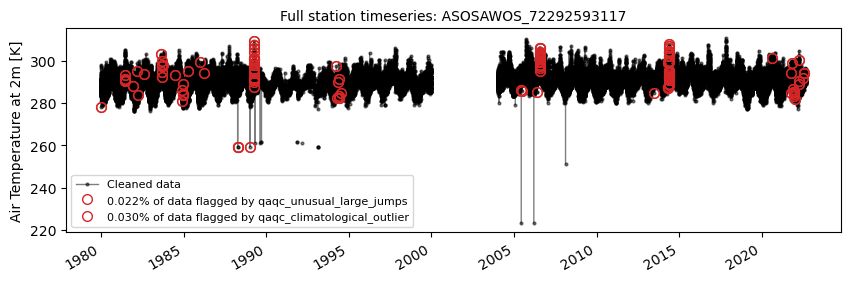

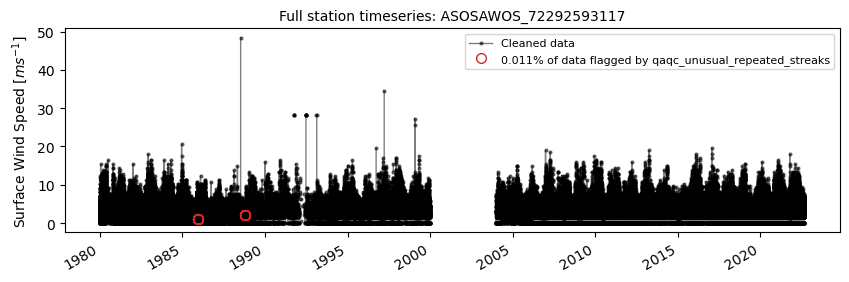

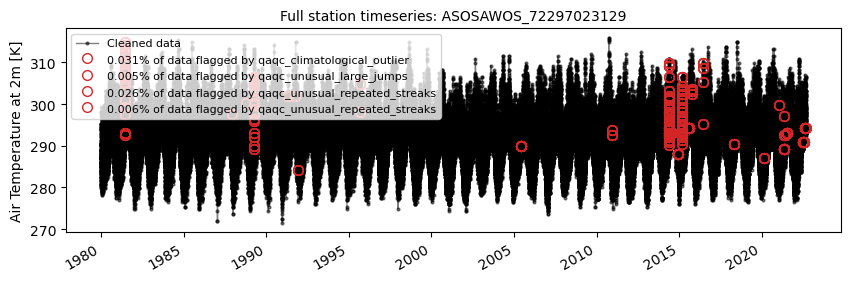

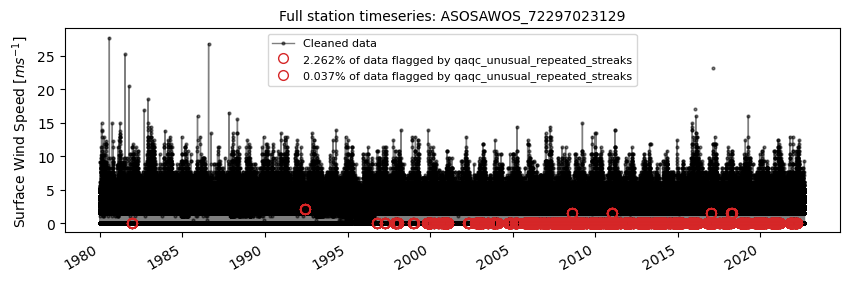

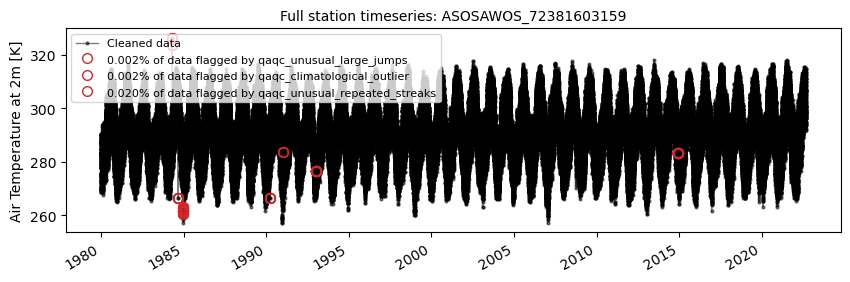

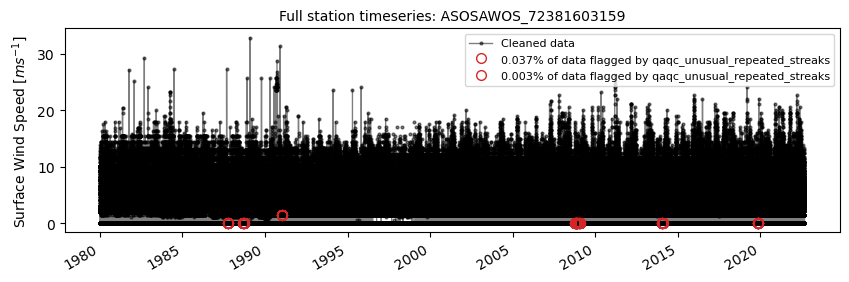

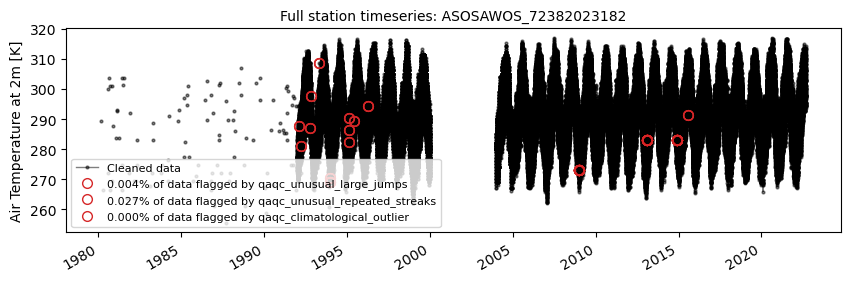

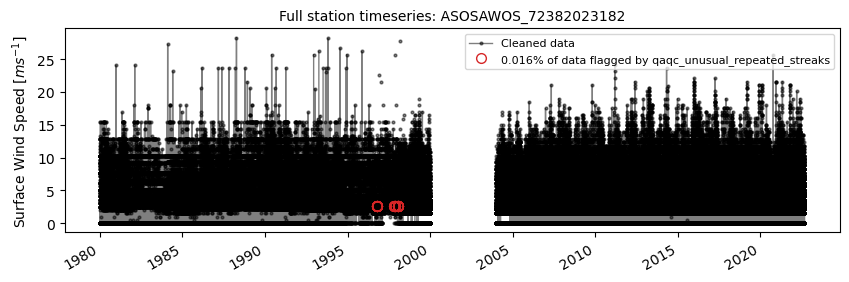

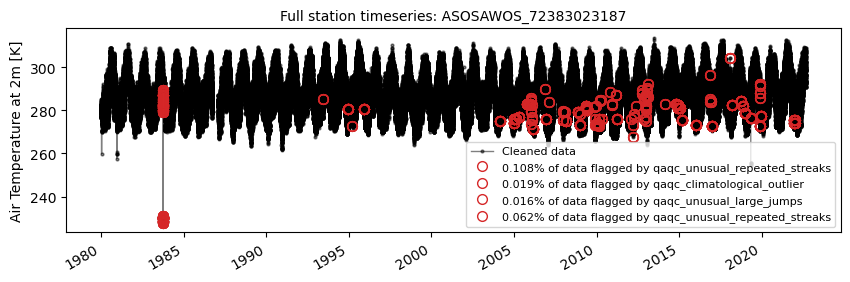

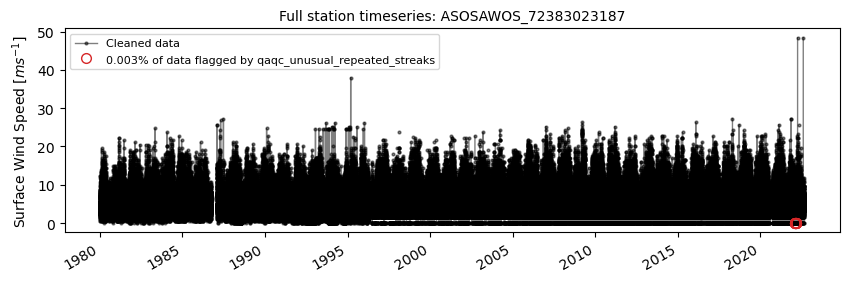

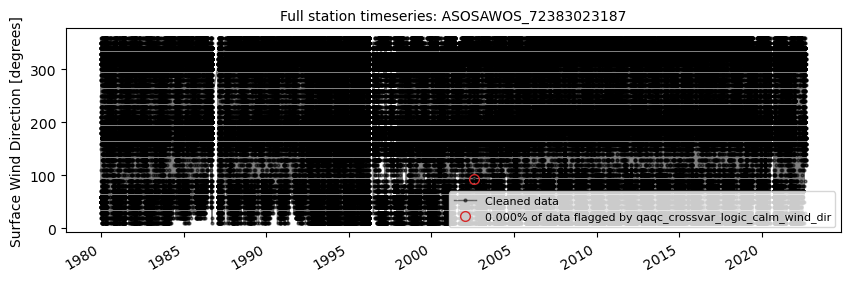

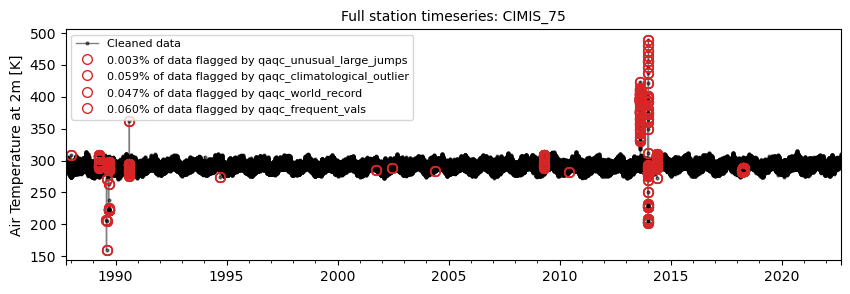

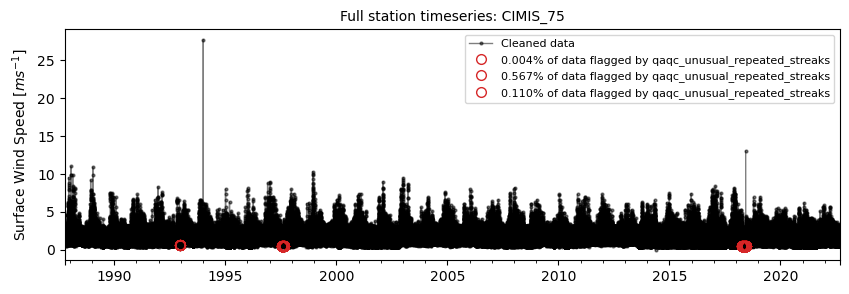

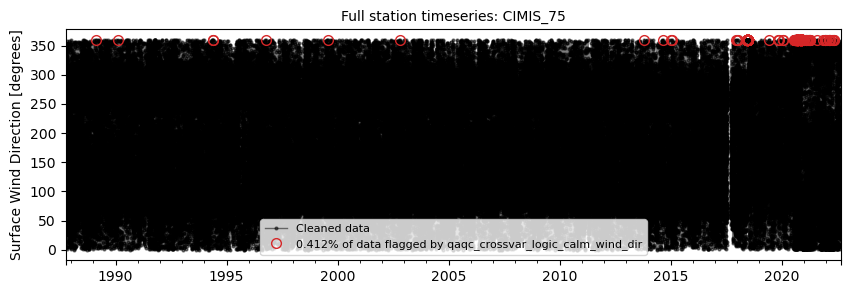

In [4]:
stns_to_run = list(eval_stations['era-id'])
multi_stn_check(stns_to_run, 'santa_ana_wind')

In [ ]:
# if continuing forward... visualize during event

In [ ]:
vars_to_check = ['tas', 'hurs', 'sfcWind', 'sfcWind_dir']
vars_to_eval = [var for var in vars_to_check if var in dd.columns]

for var in vars_to_eval:
    flagged_timeseries_plot(dd, var=var)

In [ ]:
flagged_timeseries_plot(dd, var='tas') # why no showing? 

#### Append local GHCNh library path

In [ ]:
ghcnh_lib_path = "/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_eval_notebooks/GHCNh"
sys.path.append(ghcnh_lib_path)
# from GHCNh.GHCNh_lib import GHCNh  # If GHCNh is within current folder
from GHCNh_lib import GHCNh # If GHCNh is was appended to path

In [ ]:
%%time
ghcnh = GHCNh(stations_local=True)
ghcnh.select_wecc()
id = ghcnh.stations_df['id'].iloc[0]
ghcnh.read_data_from_url(id, save=True)
ghcnh.convert_df_to_gpd()
ghcnh.station_data.head(3)

In [ ]:
lon = ghcnh.station_data.Longitude.mean()
lat = ghcnh.station_data.Latitude.mean()
print("{}, {:.5f}, {:.5f}".format(id, lon, lat))

In [ ]:
fig,ax = plt.subplots(figsize=(9,3))

ghcnh.station_data.plot(ax=ax, x="time", y="temperature")
ghcnh.station_data.plot(ax=ax, x="time", y="dew_point_temperature")
ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat));

In [ ]:
# initial test for identifying the event: large jumps on windspeed

In [ ]:
return_ghcn_vars(ghcnh.station_data, 'sfcWind').head(3)